
# DBTL Cycle with PyTorch MLP + GPyTorch GP + EI

This notebook demonstrates a DBTL (Design-Build-Test-Learn) loop using:
- A deep neural network for predictive modeling (PyTorch)
- A Gaussian Process model for uncertainty estimation (GPyTorch)
- An Expected Improvement (EI) acquisition function


In [4]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch import nn
from scipy.stats import norm

torch.manual_seed(42)
np.random.seed(42)

def true_yield_function(X):
    return (np.sin(X[:, 0]) + 0.5 * X[:, 1] - 0.2 * X[:, 2] ** 2 + 
            np.random.normal(0, 0.1, size=X.shape[0]))

In [6]:
# Test the function with proper 2D array input
test_input = np.array([[1, 1, 1]])  # Shape: (1, 3)
result = true_yield_function(test_input)
print(f"Input: {test_input[0]} → Output: {result[0]:.3f}")

# Test with multiple points
test_inputs = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [-1, -1, -1]
])
results = true_yield_function(test_inputs)
print("\nMultiple test points:")
for i, (inp, out) in enumerate(zip(test_inputs, results)):
    print(f"Point {i+1}: {inp} → {out:.3f}")

Input: [1 1 1] → Output: 1.059

Multiple test points:
Point 1: [0 0 0] → -0.125
Point 2: [1 1 1] → 1.095
Point 3: [-1 -1 -1] → -1.657


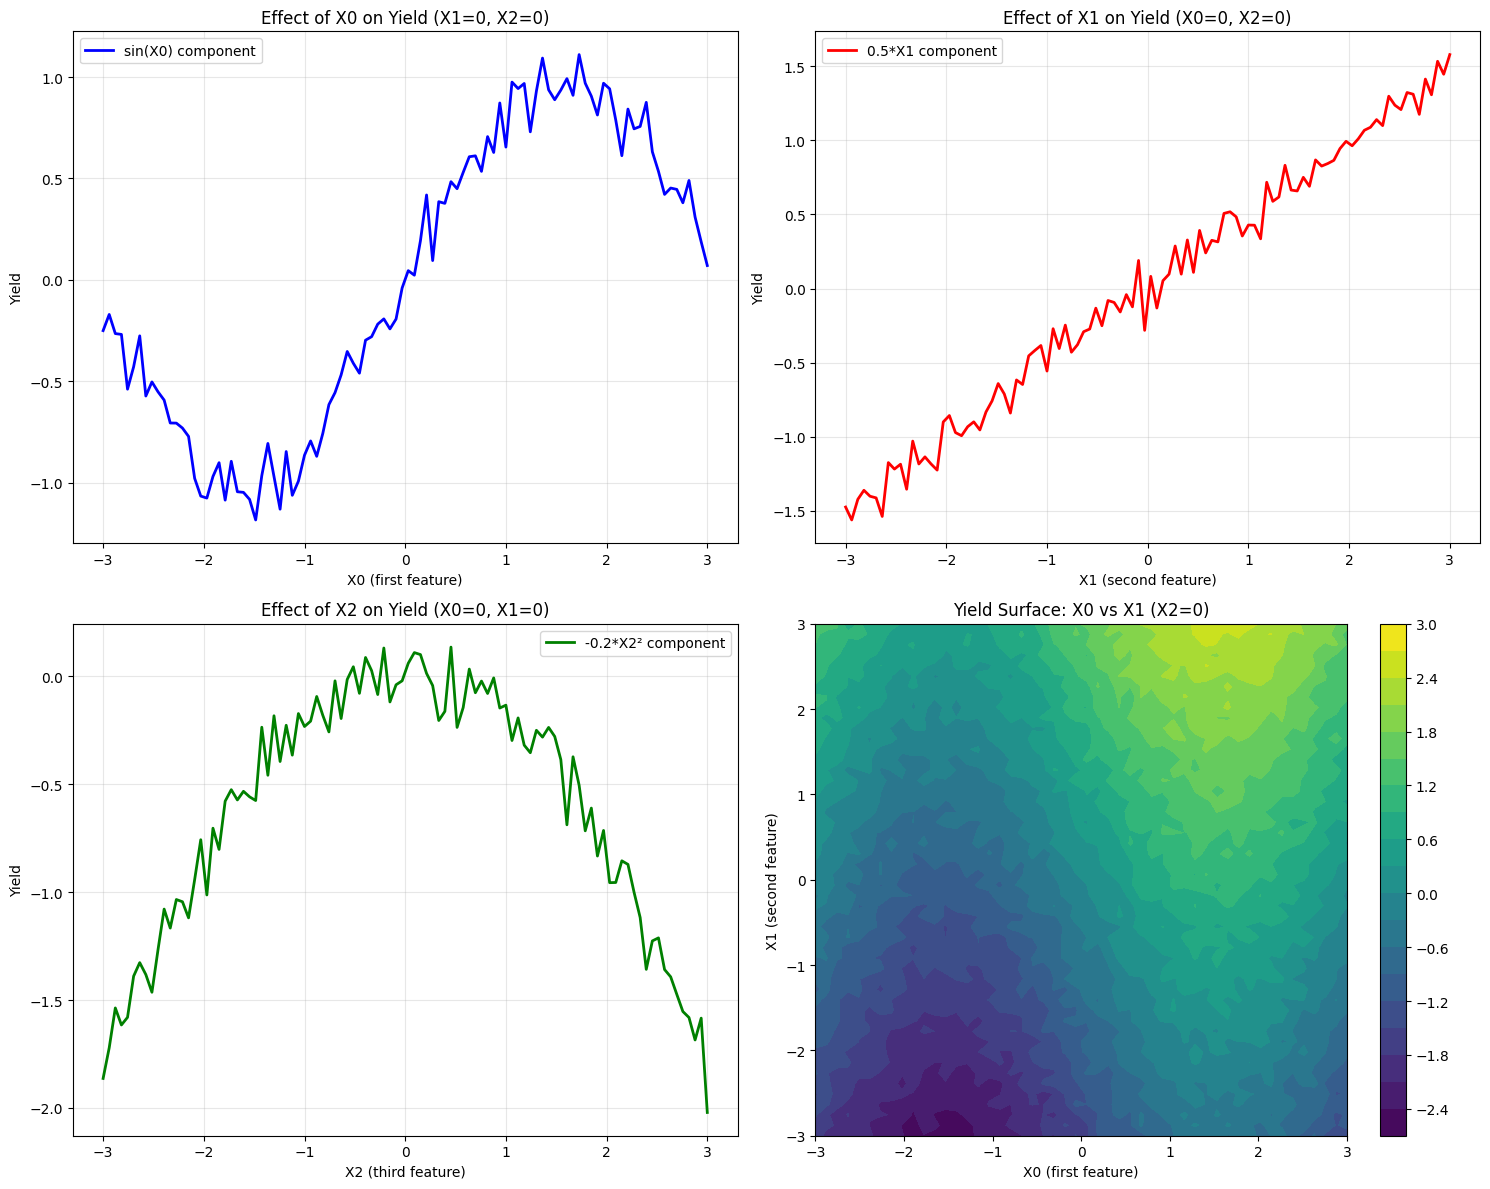

Example function outputs:
X = [0 0 0] → yield = -0.022
X = [1 1 1] → yield = 1.180
X = [-1 -1 -1] → yield = -1.570
X = [3 0 0] → yield = 0.205
X = [0 3 0] → yield = 1.437
X = [0 0 3] → yield = -1.793


In [7]:
# Visualize the true_yield_function to understand its behavior
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Effect of X0 (first feature) while keeping X1=0, X2=0
x0_range = np.linspace(-3, 3, 100)
X_x0 = np.column_stack([x0_range, np.zeros(100), np.zeros(100)])
y_x0 = true_yield_function(X_x0)

axes[0, 0].plot(x0_range, y_x0, 'b-', linewidth=2, label='sin(X0) component')
axes[0, 0].set_xlabel('X0 (first feature)')
axes[0, 0].set_ylabel('Yield')
axes[0, 0].set_title('Effect of X0 on Yield (X1=0, X2=0)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Effect of X1 (second feature) while keeping X0=0, X2=0
x1_range = np.linspace(-3, 3, 100)
X_x1 = np.column_stack([np.zeros(100), x1_range, np.zeros(100)])
y_x1 = true_yield_function(X_x1)

axes[0, 1].plot(x1_range, y_x1, 'r-', linewidth=2, label='0.5*X1 component')
axes[0, 1].set_xlabel('X1 (second feature)')
axes[0, 1].set_ylabel('Yield')
axes[0, 1].set_title('Effect of X1 on Yield (X0=0, X2=0)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Effect of X2 (third feature) while keeping X0=0, X1=0
x2_range = np.linspace(-3, 3, 100)
X_x2 = np.column_stack([np.zeros(100), np.zeros(100), x2_range])
y_x2 = true_yield_function(X_x2)

axes[1, 0].plot(x2_range, y_x2, 'g-', linewidth=2, label='-0.2*X2² component')
axes[1, 0].set_xlabel('X2 (third feature)')
axes[1, 0].set_ylabel('Yield')
axes[1, 0].set_title('Effect of X2 on Yield (X0=0, X1=0)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. 3D surface plot showing interaction between X0 and X1 (X2=0)
x0_mesh = np.linspace(-3, 3, 50)
x1_mesh = np.linspace(-3, 3, 50)
X0_grid, X1_grid = np.meshgrid(x0_mesh, x1_mesh)
X_surface = np.column_stack([X0_grid.ravel(), X1_grid.ravel(), np.zeros(X0_grid.size)])
y_surface = true_yield_function(X_surface).reshape(X0_grid.shape)

im = axes[1, 1].contourf(X0_grid, X1_grid, y_surface, levels=20, cmap='viridis')
axes[1, 1].set_xlabel('X0 (first feature)')
axes[1, 1].set_ylabel('X1 (second feature)')
axes[1, 1].set_title('Yield Surface: X0 vs X1 (X2=0)')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Print some example outputs
print("Example function outputs:")
print("="*50)
test_points = np.array([
    [0, 0, 0],      # All zeros
    [1, 1, 1],      # All ones
    [-1, -1, -1],   # All negative ones
    [3, 0, 0],      # Max X0
    [0, 3, 0],      # Max X1
    [0, 0, 3],      # Max X2
])

for i, point in enumerate(test_points):
    X_test = point.reshape(1, -1)  # Reshape to 2D array
    y_test = true_yield_function(X_test)
    print(f"X = {point} → yield = {y_test[0]:.3f}")

In [ ]:
design_space_np = np.random.uniform(low=-3, high=3, size=(1000, 3))
design_space = torch.tensor(design_space_np, dtype=torch.float)

initial_indices = np.random.choice(len(design_space), size=10, replace=False)
X_train = torch.tensor(design_space_np[initial_indices], dtype=torch.float)
y_train = torch.tensor(true_yield_function(X_train.numpy()), dtype=torch.float)

In [ ]:
class PredictiveMLP(nn.Module):
    def __init__(self, in_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

def train_predictive_model(model, X, y, epochs=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

mlp_model = PredictiveMLP()
train_predictive_model(mlp_model, X_train, y_train)
y_pred = mlp_model(design_space).detach()


In [ ]:

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = GPRegressionModel(X_train, y_train, likelihood)

gp_model.train()
likelihood.train()
optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

for i in range(50):
    optimizer.zero_grad()
    output = gp_model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()


In [ ]:

gp_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = gp_model(design_space)
    mu = preds.mean
    sigma = preds.variance.sqrt()

y_best = y_train.max()
improvement = mu - y_best
Z = improvement / (sigma + 1e-8)
ei = improvement * torch.tensor(norm.cdf(Z)) + sigma * torch.tensor(norm.pdf(Z))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(range(len(design_space)), y_pred.numpy(), alpha=0.6)
axs[0].set_title("MLP Predicted Yield")
axs[0].set_xlabel("Design Index")
axs[0].set_ylabel("Predicted Yield")

axs[1].plot(mu.numpy(), label='GP Mean')
axs[1].fill_between(range(len(sigma)), mu.numpy() - sigma.numpy(), mu.numpy() + sigma.numpy(), alpha=0.3)
axs[1].set_title("GP Posterior Mean ± Std")
axs[1].set_xlabel("Design Index")
axs[1].set_ylabel("Yield")

axs[2].plot(ei.numpy(), color='green')
axs[2].set_title("Expected Improvement")
axs[2].set_xlabel("Design Index")
axs[2].set_ylabel("EI Score")

plt.tight_layout()
plt.show()
